#NLP For News Classification

###Dataset From Kaggle

Tutorial From https://www.kaggle.com/discussions/general/74235

In [1]:
# install kaggle package
!pip install -q kaggle
!pip install -q emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 3.9 MB/s eta 0:00:00


In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"syaraihanheggi","key":"9051a00f0ad049f542afa95891c38d02"}'}

In [3]:
# make directory and change permission
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

# test kaggle dataset list
!kaggle datasets list

kaggle.json
ref                                                                  title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                      DAIGT V2 Train Dataset                               29MB  2023-11-16 01:38:36           1509        154  1.0              
muhammadbinimran/housing-price-prediction-data                       Housing Price Prediction Data                       763KB  2023-11-21 17:56:32           6755        120  1.0              
thedevastator/netflix-imdb-scores                                    Netflix IMDB Scores                                 699KB  2023-12-03 14:10:34           2120         37  1.0              
thedevastator/summer-pr

In [4]:
# download dataset, choose 'copy api command' from kaggle dataset
!kaggle datasets download -d lokkagle/movie-genre-data

 53% 5.00M/9.46M [00:00<00:00, 29.0MB/s]
100% 9.46M/9.46M [00:00<00:00, 50.8MB/s]


In [5]:
# unzip
!mkdir movie-genre-data
!unzip movie-genre-data.zip -d dataset
!ls dataset

Archive:  movie-genre-data.zip
  inflating: dataset/kaggle_movie_train.csv  
kaggle_movie_train.csv


###Load Dataset

In [6]:
# import pandas
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# load json dataset
df = pd.read_csv(r'/content/dataset/kaggle_movie_train.csv', sep=",")
df.head(10)

,id,text,genre
0,0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,2,"t, summa cum laude and all. And I'm about to l...",comedy
2,3,"up Come, I have a surprise.... She takes him ...",drama
3,4,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,5,"nd dismounts, just as the other children reach...",drama
5,6,breadth of the bluff. Gabe pulls out his ancie...,thriller
6,7,uilding. A MAN in pajamas runs out into the ra...,thriller
7,9,ELLES AND RITA HAYWORTH Just disgustingly rich...,drama
8,10,"Memphis goes back into the garage, Budgy cack...",thriller
9,11,e reels as the world spins. Sweat pours off hi...,action


In [8]:
# Check Shape
df.shape

(22579, 3)

In [9]:
# Data Types
df.dtypes

id        int64
text     object
genre    object
dtype: object

In [10]:
# Check Genre Count
df.genre.value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

<Axes: title={'center': 'Proportion of genre'}>

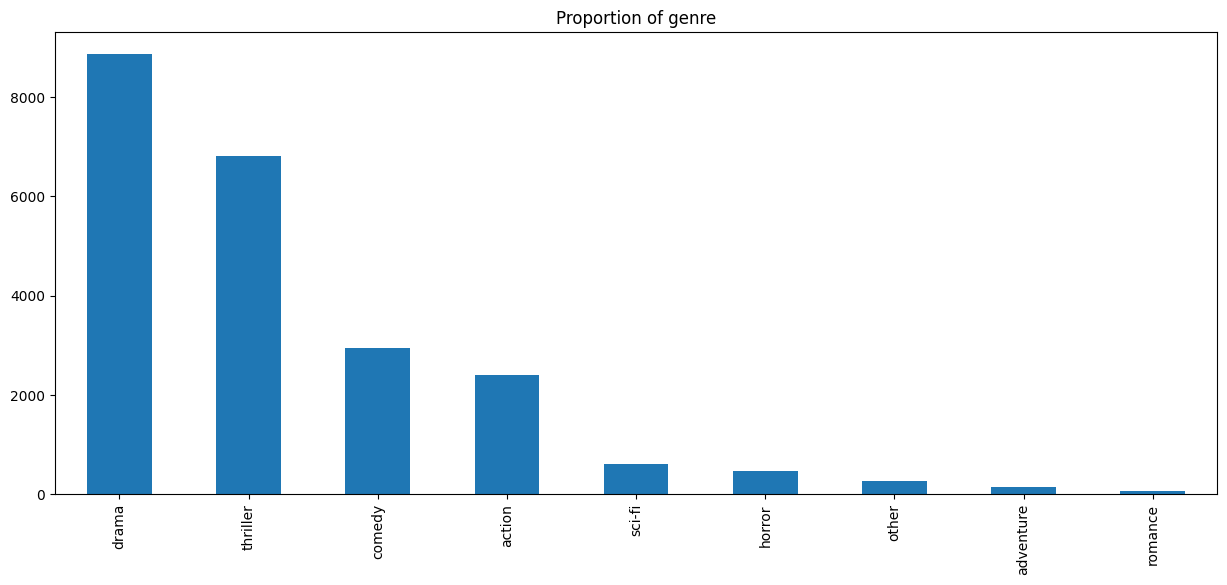

In [11]:
df['genre'].value_counts().plot.bar(figsize=(15,6),title="Proportion of genre")

###Data Exploration

In [12]:
import missingno as msno
import regex as re
import emoji

import nltk, os, re, string

from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [13]:
# check missing value
df.isnull().sum()

id       0
text     0
genre    0
dtype: int64

In [14]:
# Selecting Data
df = df[['text','genre']].copy()
df

,text,genre
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller
1,"t, summa cum laude and all. And I'm about to l...",comedy
2,"up Come, I have a surprise.... She takes him ...",drama
3,ded by the two detectives. INT. JEFF'S APARTME...,thriller
4,"nd dismounts, just as the other children reach...",drama
...,...,...
22574,n in the world to decide what I'm going to do ...,drama
22575,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,....with marked skill and dexterity . LANA wry...,action


####Checking Emoji

In [15]:
# Data With Emoji (Not Detected Missing Value)
df2 = df[df['text'].str.contains(r'[\u263a-\U0001f645]')]
df2

,text,genre


In [16]:
# Data With HTML Tags  (Uncomment Line Of Codee)

df2 = df[df['text'].str.contains(r'<[^<>]*>')]
df2

,text,genre


###Data Cleansing

In [17]:
# Cleaning data
def remove(text):
  #remove mention
  text = re.sub("@[A-Za-z0-9_]+","", text)
  # remove stock market tickers like $GE
  text = re.sub(r'\$\w*', '', text)
  # remove old style retext text "RT"
  text = re.sub(r'^RT[\s]+', '', text)
  text = re.sub(r'^rt[\s]+', '', text)
  # remove hyperlinks
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'^https[\s]+', '', text)
  # remove hashtags
  text = re.sub(r'#', '', text)
  text = re.sub(r'%', '', text)
  #remove coma
  text = re.sub(r',','',text)
  #remove angka
  text = re.sub('[0-9]+', '', text)
  text = re.sub(r':', '', text)
  #remove space
  text = text.strip()
  #remove double space
  text = re.sub('\s+',' ',text)
  # remove emoji
  text = re.sub(r'[\u263a-\U0001f645]','',text)

  return text

def clean_punctuation(data):
    return(data.translate(str.maketrans('','', string.punctuation)))

stopword = set(stopwords.words('english'))
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword)
    return text


lemmatizer = WordNetLemmatizer()
def lematization(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))

In [18]:
# Cleanse from non alphanumerical string and lowering
df['cleaning_text'] = df['text'].apply(lambda x: remove(x.lower()))
df.head(10)

,text,genre,cleaning_text
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller,eady dead maybe even wishing he was. int. nd f...
1,"t, summa cum laude and all. And I'm about to l...",comedy,t summa cum laude and all. and i'm about to la...
2,"up Come, I have a surprise.... She takes him ...",drama,up come i have a surprise.... she takes him by...
3,ded by the two detectives. INT. JEFF'S APARTME...,thriller,ded by the two detectives. int. jeff's apartme...
4,"nd dismounts, just as the other children reach...",drama,nd dismounts just as the other children reach ...
5,breadth of the bluff. Gabe pulls out his ancie...,thriller,breadth of the bluff. gabe pulls out his ancie...
6,uilding. A MAN in pajamas runs out into the ra...,thriller,uilding. a man in pajamas runs out into the ra...
7,ELLES AND RITA HAYWORTH Just disgustingly rich...,drama,elles and rita hayworth just disgustingly rich...
8,"Memphis goes back into the garage, Budgy cack...",thriller,memphis goes back into the garage budgy cackle...
9,e reels as the world spins. Sweat pours off hi...,action,e reels as the world spins. sweat pours off hi...


In [19]:
# Cleaning Stop Words
df['cleaning_text'] = df['cleaning_text'].apply(lambda x: clean_stopwords(x))

In [20]:
# Clean Punctuation
df['cleaning_text'] = df['cleaning_text'].apply(lambda x: clean_punctuation(x))

In [21]:
# Lemmatization
df['cleaning_text'] = df['cleaning_text'].apply(lambda x: lematization(x))

In [22]:
# Encode Genre to Numerical  (One Hot Encoding)
genre = pd.get_dummies(df.genre)
df = pd.concat([df, genre], axis=1)
genre.columns

Index(['action', 'adventure', 'comedy', 'drama', 'horror', 'other', 'romance',
       'sci-fi', 'thriller'],
      dtype='object')

In [23]:
# Check DF After Cleansing
df

,text,genre,cleaning_text,action,adventure,comedy,drama,horror,other,romance,sci-fi,thriller
0,"eady dead, maybe even wishing he was. INT. 2ND...",thriller,eady dead maybe even wishing wa int nd floor h...,0,0,0,0,0,0,0,0,1
1,"t, summa cum laude and all. And I'm about to l...",comedy,summa cum laude all im launch brand new magazi...,0,0,1,0,0,0,0,0,0
2,"up Come, I have a surprise.... She takes him ...",drama,come surprise take hand lead hallway salvatore...,0,0,0,1,0,0,0,0,0
3,ded by the two detectives. INT. JEFF'S APARTME...,thriller,ded two detective int jeffs apartment night me...,0,0,0,0,0,0,0,0,1
4,"nd dismounts, just as the other children reach...",drama,nd dismount child reach him throw arm embracin...,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
22574,n in the world to decide what I'm going to do ...,drama,n world decide im going thats me think think e...,0,0,0,1,0,0,0,0,0
22575,shards. BOJO LAZ! Laz pushes Deke back through...,drama,shard bojo laz laz push deke back joint slam o...,0,0,0,1,0,0,0,0,0
22576,"OTTIE You've got a thing about Ernie's, haven'...",thriller,ottie got thing ernies you judy well place com...,0,0,0,0,0,0,0,0,1
22577,....with marked skill and dexterity . LANA wry...,action,with marked skill dexterity lana wryly surpris...,1,0,0,0,0,0,0,0,0


In [85]:
# Convert Array Data
text = df['cleaning_text'].astype(str)
label = df[['action', 'adventure', 'comedy', 'drama', 'horror', 'other', 'romance',
       'sci-fi', 'thriller']].values

In [86]:
# Show text
text

0        eady dead maybe even wishing wa int nd floor h...
1        summa cum laude all im launch brand new magazi...
2        come surprise take hand lead hallway salvatore...
3        ded two detective int jeffs apartment night me...
4        nd dismount child reach him throw arm embracin...
                               ...                        
22574    n world decide im going thats me think think e...
22575    shard bojo laz laz push deke back joint slam o...
22576    ottie got thing ernies you judy well place com...
22577    with marked skill dexterity lana wryly surpris...
22578    rd walk hallway leaving post end hallway see b...
Name: cleaning_text, Length: 22579, dtype: object

In [87]:
# Show Label
label

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

###Model Creation

In [135]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [89]:
# Split data into training and validation
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [148]:
# tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token='<oov>')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

seq_train = tokenizer.texts_to_sequences(text_train)
seq_test = tokenizer.texts_to_sequences(text_test)

padded_train = pad_sequences(seq_train, padding='post', maxlen=100, truncating='post')
padded_test = pad_sequences(seq_test, padding='post', maxlen=100, truncating='post')

In [155]:
# model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(24),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation='softmax')
])

Adam(learning_rate=0.00146, name='Adam')
model.compile(optimizer='Adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 16)          80000     
                                                                 
 dropout_39 (Dropout)        (None, None, 16)          0         
                                                                 
 lstm_21 (LSTM)              (None, 24)                3936      
                                                                 
 dropout_40 (Dropout)        (None, 24)                0         
                                                                 
 dense_42 (Dense)            (None, 128)               3200      
                                                                 
 dropout_41 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 9)               

In [156]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")

callbacks = myCallback()

In [157]:
history = model.fit(padded_train, label_train, epochs=50, validation_data=(padded_test, label_test), verbose=1, callbacks=[callbacks])

Epoch 1/50
565/565 [==============================] - 21s 33ms/step - loss: 1.4905 - accuracy: 0.3902 - val_loss: 1.1880 - val_accuracy: 0.4708
Epoch 2/50
565/565 [==============================] - 7s 12ms/step - loss: 1.1314 - accuracy: 0.4731 - val_loss: 1.0982 - val_accuracy: 0.4838
Epoch 3/50
565/565 [==============================] - 6s 10ms/step - loss: 1.0617 - accuracy: 0.4867 - val_loss: 1.0791 - val_accuracy: 0.4894
Epoch 4/50
565/565 [==============================] - 8s 14ms/step - loss: 1.0140 - accuracy: 0.4948 - val_loss: 1.0908 - val_accuracy: 0.4854
Epoch 5/50
565/565 [==============================] - 5s 9ms/step - loss: 0.9737 - accuracy: 0.4987 - val_loss: 1.0514 - val_accuracy: 0.4920
Epoch 6/50
565/565 [==============================] - 5s 9ms/step - loss: 0.9546 - accuracy: 0.4993 - val_loss: 1.0591 - val_accuracy: 0.4962
Epoch 7/50
565/565 [==============================] - 6s 10ms/step - loss: 0.9231 - accuracy: 0.5367 - val_loss: 1.0654 - val_accuracy: 0.5188


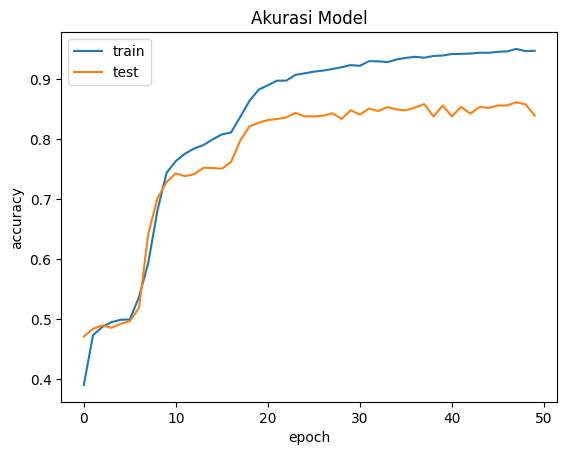

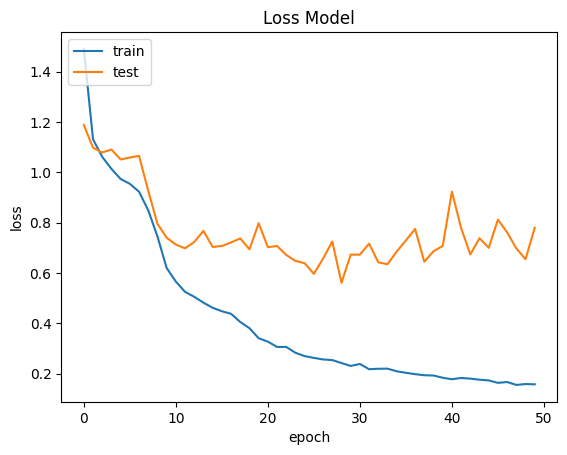

In [159]:
# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()